In [10]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree

# Para realizar la regresión lineal y la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


from sklearn.model_selection import KFold,LeaveOneOut, cross_val_score


from sklearn.preprocessing import StandardScaler

from tqdm import tqdm


# Ignorar los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

import sys 
sys.path.append("../")
from src.soporte_metricas import (
    obtener_metricas,
    residual_plot,
    generar_df_comparador
)
pd.options.display.float_format = "{:,.2f}".format

In [7]:
df = pd.read_csv("../datos/06_autorenew_target_encoded.csv", index_col = 0)

# Gradient Boosting
### Parámetros
- n_estimators: Número de árboles en el modelo
    - Cuantos más, habrá más precisión
- learning_rate: Velocidad de aprendizaje
    - 0.01: Lento y estable
    - 0.1: Equilibrado
    - 0.2: Rápido y riesgoso
- max_depth: Profundidad máxima del árbol
    - 3: 3 niveles de decisión
    - 5: 5 niveles, más profundo y detallado
    - A más profundo, más precisión
- min_samples_split: Número mínimo de datos para dividir un nodo
    - 2: Si al menos hay 2 datos se puede dividir
    - 10: Si al menos hay 10 datos podrá dividirse
- min_samples_leaf: Mínimo de datos en una hoja
    - 1: Cada hoja tiene mínimo un dato
    - 4: Cada hoja tiene mínimo 4 datos

In [8]:
X = df.drop(columns="price")
y = df[["price"]]
X_train, X_test, y_train, y_test = train_test_split(X, # Todo menos la Variable Respuesta
                                                    y, # La variable Respuesta
                                                    train_size=0.7, # Como dividir los datos en este caso 80% train, 20% test
                                                    random_state=42, # Semilla, para que lo haga igual para cualquier persona
                                                    shuffle=True 
                                                    )

In [11]:
modelo_arbol = GradientBoostingRegressor()
modelo_arbol.fit(X_train,y_train)
y_pred_test = modelo_arbol.predict(X_test)
y_pred_train = modelo_arbol.predict(X_train)
df_metricas = obtener_metricas(y_train,y_pred_train,y_test,y_pred_test)
df_metricas

,r2_score,MAE,MSE,RMSE
train,0.75,"2,076.35","13,772,749.24","3,711.17"
test,0.75,"2,058.36","13,265,901.35","3,642.24"


In [ ]:
params_gb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [15]:
# Parámetros a evaluar
params_gb = {
    'n_estimators': [50,100,150],
    'learning_rate': [0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [5,10],
    'min_samples_leaf': [2,4]
}

grid_search_gb = GridSearchCV(GradientBoostingRegressor(random_state=42),
                                 param_grid= params_gb,
                                 cv = 5, # Cross Validation de 5 grupos solo
                                 scoring="neg_mean_squared_error",
                                 n_jobs=-1)


grid_search_gb.fit(X_train, y_train.to_numpy().ravel())
modelo_final_gb = grid_search_gb.best_estimator_


# Ver el mejor modelo de los elegidos

In [16]:
modelo_final_gb

GradientBoostingRegressor(max_depth=5, min_samples_leaf=4, min_samples_split=5,
                          n_estimators=150, random_state=42)

# Vemos las métricas

In [17]:
y_pred_test_gb = modelo_final_gb.predict(X_test)
y_pred_train_gb = modelo_final_gb.predict(X_train)

resultados_gb= obtener_metricas(y_train,y_pred_train,y_test,y_pred_test)
resultados_gb

,r2_score,MAE,MSE,RMSE
train,0.75,"2,076.35","13,772,749.24","3,711.17"
test,0.75,"2,058.36","13,265,901.35","3,642.24"


# Pasamos los resultados a un DF

In [19]:
# Resultados del GridSearchCV
resultados_gb = pd.DataFrame(grid_search_gb.cv_results_)

# Extraemos el impacto de los parámetros

In [20]:
# Extraer el impacto de cada parámetro principal
impacto_gb = resultados_gb[['param_n_estimators', 'param_learning_rate', 
                            'param_max_depth', 'param_min_samples_split', 
                            'param_min_samples_leaf', 'mean_test_score']]
impacto_gb['mean_test_score'] = -impacto_gb['mean_test_score']  # Convertir a MSE positivo

# Visualizamos el impacto de cada parámetro

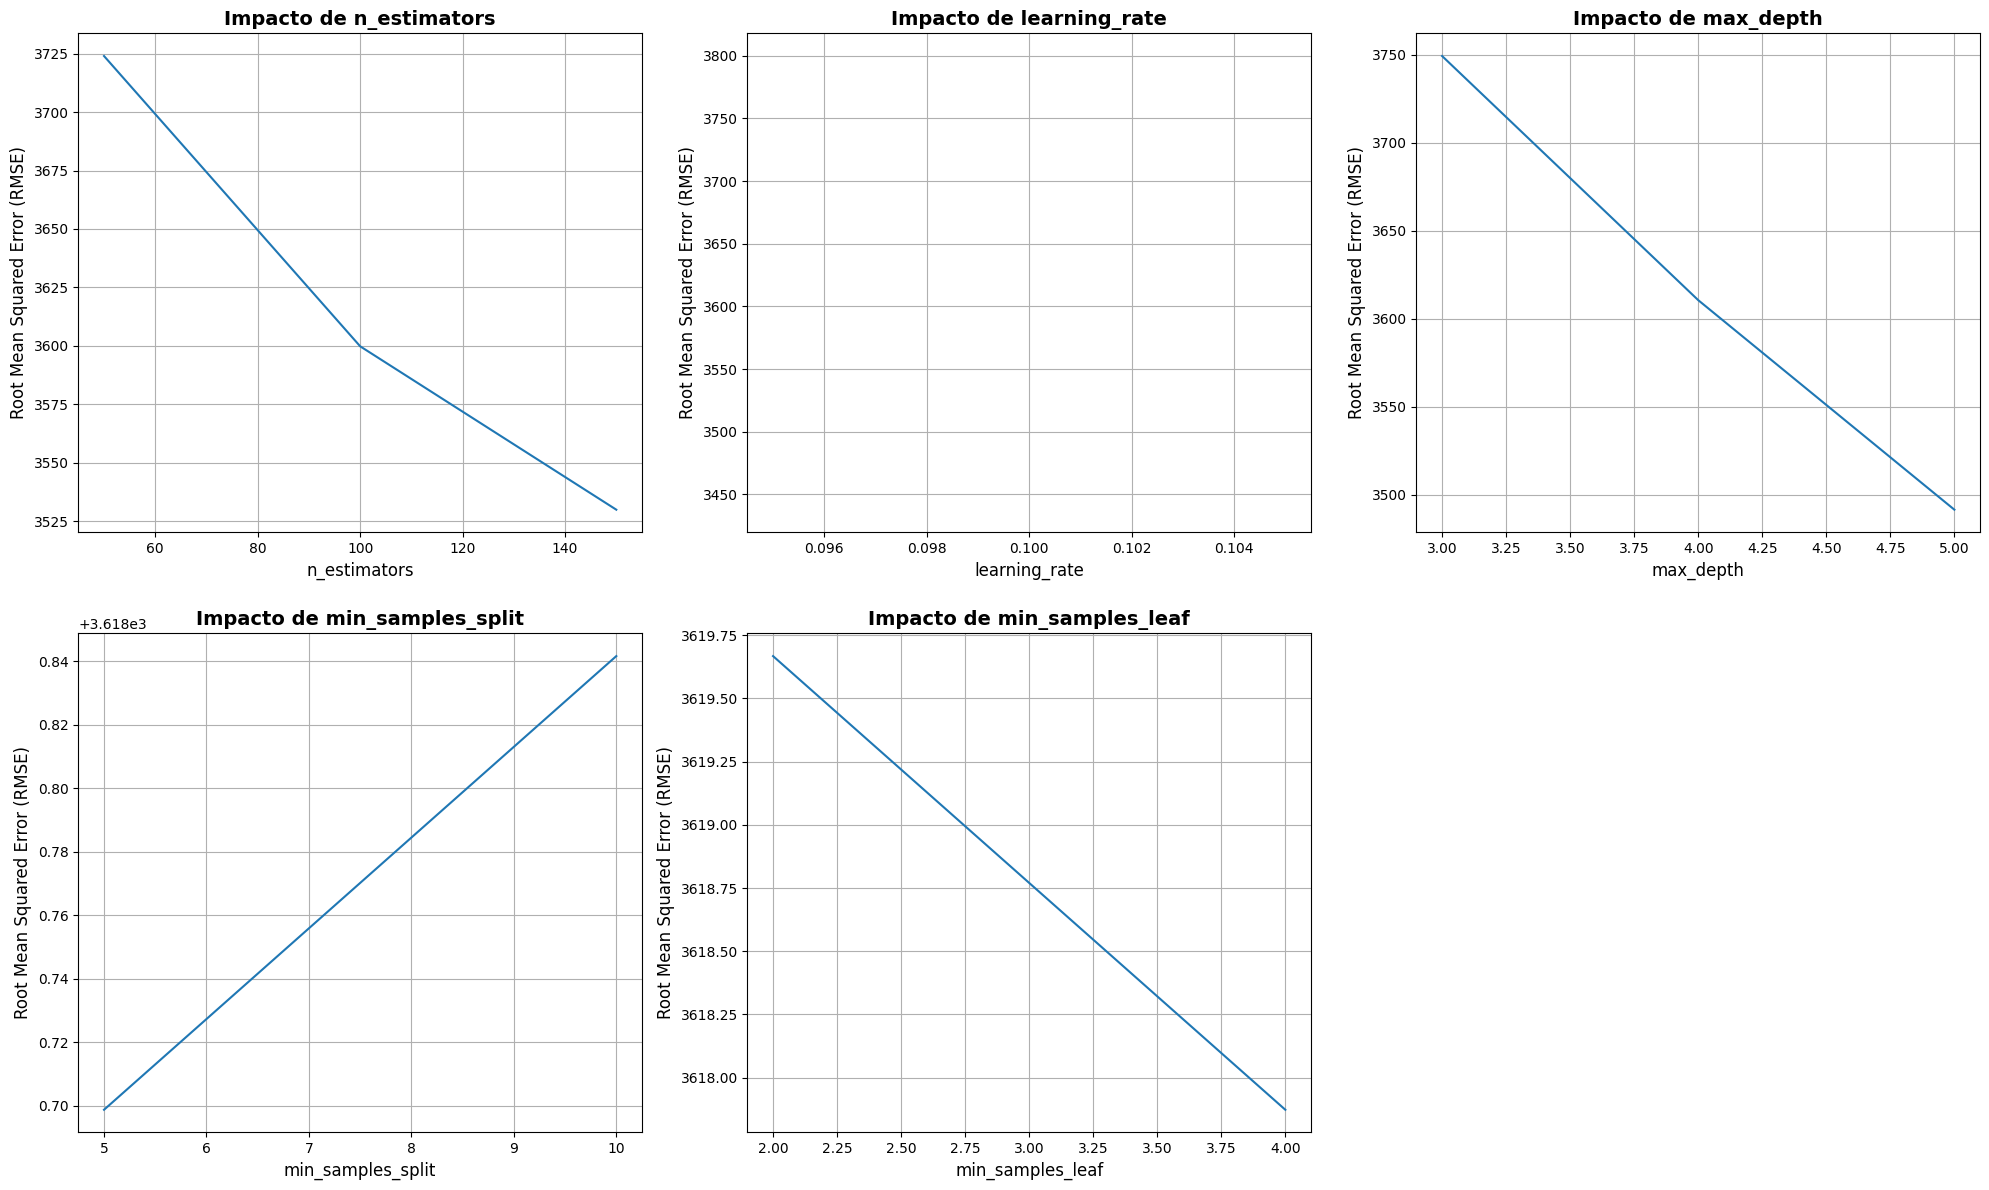

In [21]:
# Visualización del impacto de cada parámetro
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
axs = axs.flat
parametros_gb = impacto_gb.columns[:-1]
titulos_gb = ['Impacto de n_estimators', 'Impacto de learning_rate',
              'Impacto de max_depth', 'Impacto de min_samples_split',
              'Impacto de min_samples_leaf']

for indice, columns in enumerate(parametros_gb):
    df_resultados_gb = impacto_gb.groupby(columns)['mean_test_score'].mean().reset_index()
    df_resultados_gb['sqrt_mean_test_score'] = np.sqrt(df_resultados_gb['mean_test_score'])
    sns.lineplot(x=columns, y="sqrt_mean_test_score", data=df_resultados_gb, ax=axs[indice])
    axs[indice].set_title(titulos_gb[indice], fontsize=14, fontweight='bold')
    axs[indice].set_xlabel(columns.replace('param_', ''), fontsize=12)
    axs[indice].set_ylabel('Root Mean Squared Error (RMSE)', fontsize=12)
    axs[indice].grid(True)

fig.delaxes(axs[-1])
plt.tight_layout()
plt.show()

In [22]:
# Imprimir el mejor modelo
print("Mejor modelo encontrado para Gradient Boosting:")
print(modelo_final_gb)

Mejor modelo encontrado para Gradient Boosting:
GradientBoostingRegressor(max_depth=5, min_samples_leaf=4, min_samples_split=5,
                          n_estimators=150, random_state=42)
